## 🧠 Answer Synthesis from Multiple Sources
What Is It?

Answer synthesis from multiple sources is the process where an AI agent collects information from different retrieval tools or knowledge bases, and merges that information into a single, coherent, and contextually rich answer.

This is a core capability in Agentic RAG, where the system is more than just a simple retriever — it plans, retrieves, and then synthesizes an answer that draws from multiple sources.



🎯 Why It’s Needed
Most real-world queries are:
- Multifaceted (require multiple types of information)
- Ambiguous or incomplete (need refinement)
- Open-ended (don’t map to a single document or source)

🔍 This makes retrieving from a single vector DB insufficient.

Instead, we want an agent that can:

- Decide what to fetch from where (retrieval planning)
- Retrieve content from multiple tools (e.g., Wikipedia, PDFs, APIs, SQL)
- Evaluate and merge that context
- Produce a single human-like response

In [6]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders.youtube import YoutubeLoader
from langchain_community.document_loaders import ArxivLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END

In [25]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o-mini")

In [26]:
def load_text_retriever(file_path):
    docs = TextLoader(file_path, encoding="utf-8").load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    return vs.as_retriever()

def load_youtube_retriever():
    # Mocked YouTube transcript text
    content = """
    This video explains how agentic AI systems rely on feedback loops, memory, and tool use.
    It compares them to traditional pipeline-based LLMs. Temporal reasoning and autonomous tasking are emphasized.
    """
    doc = Document(page_content=content, metadata={"source": "youtube"})
    vectorstore = FAISS.from_documents([doc], OpenAIEmbeddings())
    return vectorstore.as_retriever()



def wikipedia_search(query: str) -> str:
    print("🌐 Searching Wikipedia...")
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())(query)

def arxiv_search(query: str) -> str:
    print("📄 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content for doc in results[:2]) or "No relevant papers found."

In [27]:
text_retriever = load_text_retriever("internal_docs.txt")
youtube_retriever = load_youtube_retriever()

In [28]:
### state
class MultiSourceRAGState(BaseModel):
    question: str
    text_docs: List[Document] = []
    yt_docs: List[Document] = []
    wiki_context: str = ""
    arxiv_context: str = ""
    final_answer: str = ""

In [29]:
### Retrieval Nodes
def retrieve_text(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = text_retriever.invoke(state.question)
    return state.model_copy(update={"text_docs": docs})

def retrieve_yt(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = youtube_retriever.invoke(state.question)
    return state.model_copy(update={"yt_docs": docs})

def retrieve_wikipedia(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = wikipedia_search(state.question)
    return state.model_copy(update={"wiki_context": result})

def retrieve_arxiv(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = arxiv_search(state.question)
    return state.model_copy(update={"arxiv_context": result})

In [30]:
## synthesize
def synthesize_answer(state: MultiSourceRAGState) -> MultiSourceRAGState:
    
    context = ""

    context += "\n\n[Internal Docs]\n" + "\n".join([doc.page_content for doc in state.text_docs])
    context += "\n\n[YouTube Transcript]\n" + "\n".join([doc.page_content for doc in state.yt_docs])
    context += "\n\n[Wikipedia]\n" + state.wiki_context
    context += "\n\n[ArXiv]\n" + state.arxiv_context

    prompt = f"""You have retrieved relevant context from multiple sources. Now synthesize a complete and coherent answer.

Question: {state.question}

Context:
{context}

Final Answer:"""

    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"final_answer": answer})

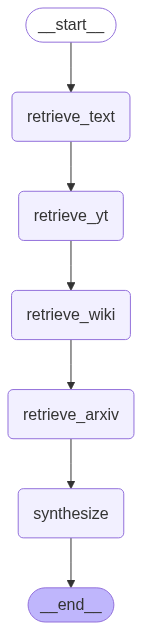

In [31]:
builder = StateGraph(MultiSourceRAGState)

builder.add_node("retrieve_text", retrieve_text)
builder.add_node("retrieve_yt", retrieve_yt)
builder.add_node("retrieve_wiki", retrieve_wikipedia)
builder.add_node("retrieve_arxiv", retrieve_arxiv)
builder.add_node("synthesize", synthesize_answer)

builder.set_entry_point("retrieve_text")
builder.add_edge("retrieve_text", "retrieve_yt")
builder.add_edge("retrieve_yt", "retrieve_wiki")
builder.add_edge("retrieve_wiki", "retrieve_arxiv")
builder.add_edge("retrieve_arxiv", "synthesize")
builder.add_edge("synthesize", END)

graph = builder.compile()
graph

In [33]:
question = "What are transformer agents and how are they evolving in recent research?"
state = MultiSourceRAGState(question=question)
result = graph.invoke(state)

print("✅ Final Answer:\n")
print(result["final_answer"])


🌐 Searching Wikipedia...
📄 Searching ArXiv...
✅ Final Answer:

Transformer agents refer to advanced AI systems that employ transformer models, like Large Language Models (LLMs), for complex tasks requiring understanding, reasoning, and interaction. These agents can autonomously perform a range of activities, incorporating feedback loops for improvement and adapting their responses based on user input and achieved outcomes. Integral to their functioning are elements such as memory and tool use, which allow them to navigate tasks beyond simple query responses.

Recent research has focused on the evolving capabilities of transformer agents, particularly in enhancing their performance in various domains. Breakthroughs include:

1. **Task Adaptation**: Transformer agents are being refined for specialized tasks such as quality control in manufacturing and voice recognition in speech applications. For example, models like Vision Transformers have shown effective results in manufacturing-relat